In [54]:
from salad.serialize import read, write
from salad.analysis.plot import plot_cluster, plot_result, plot_fake, plot_catalog
import astropy.table
import os

In [99]:
def load_recovery(pg, detector, snr):
    search_path = f"../search/tmp/DEEP/{pg}/detector_{detector}/snr_{snr}"
    
    catalog = read(os.path.join(search_path, "catalog.pkl"))
    recovery = read(os.path.join(search_path, "recovery.pkl"))
    catalog_findable = read(os.path.join(search_path, "catalog_detectable.pkl"))
    search_findable = read(os.path.join(search_path, "search_detectable.pkl"))
    detector_fakes = read(os.path.join(search_path, "..", "fakes.pkl"))
    clusters = read(os.path.join(search_path, "gather_2.pkl"))
    
    return catalog, detector_fakes, recovery, catalog_findable, search_findable, clusters

In [205]:
from fuctools import lru_cache

@lru_cache(maxsize=512)
def completeness(pointing_group, snr, detectors=list(range(1, 63))):
    c = []
    for detector in detectors:
        try:
            detector_catalog, detector_fakes, recovery, catalog_findable, search_findable, clusters = load_recovery(
                pointing_group, detector, snr
            )
        except (FileNotFoundError, EOFError) as e:
            print(pointing_group, detector, snr, e)
            continue
            
        did_find = {
            orbit: any([v/catalog_findable[orbit] > 0.6 for k, v in recovery[orbit].items()]) for orbit in recovery
        }
        for orbit in did_find:
            c.append(
                dict(
                    orbit=orbit,
                    detector=detector,
                    mag=detector_fakes[detector_fakes['ORBITID'] == orbit][0]['MAG'],
                    found=did_find[orbit],
                    catalog_possible=catalog_findable[orbit] > 25,
                    search_possible=search_findable[orbit]['findable']
                )
            )

    c = astropy.table.Table(c)
    return c


ModuleNotFoundError: No module named 'fuctools'

In [157]:
def bin_detection(catalog, min_mag, max_mag, dm=0.5, min_visits=10):
    fraction_recovered = []
    i = 0
    m = min_mag
    mag = []
    lower = min_mag
    errors = []
    while lower < max_mag:
        lower = min_mag + i * dm
        upper = min_mag + (i + 1) * dm
        a = catalog[(catalog['mag'] >= lower) & (catalog['mag'] < upper)]
        if len(a) > 0:
            num_recovered = a['found'].sum()
            num_possible = len(a)#a['catalog_possible'].sum()
            
            fraction_recovered.append(num_recovered/num_possible)
            mag.append((upper + lower) / 2)
            # num_recovered / num_total
            # sqrt(dx^2 + dy^2)
            errors.append((num_recovered**0.5)/num_possible)
#             errors.append((num_recovered + num_possible)**-0.5) # sqrt(dr**2 + da**2) where dr=sqrt(r)

        i += 1

    return mag, fraction_recovered, errors

from scipy.optimize import minimize, curve_fit
import numpy as np
from autograd import elementwise_grad as egrad
from autograd import jacobian, hessian
import autograd.numpy as np

def p(m, c, k, m_50):
    return c / (1 + np.exp(k * (m - m_50)))

def log_p(m, c, k, m_50):
    return np.log(c) - np.log(1 + np.exp(k * (m - m_50)))

def p_3(m, c, k1, k2, m_25):
    return p(m, c, k1, m_25) * p(m, 1, k2, m_25)

def log_p_3(m, c, k1, k2, m_25):
    return log_p(m, c, k1, m_25) + log_p(m, 1, k2, m_25)

def log_l(c, k, m_50, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -np.inf
    return np.sum(log_p(recovered_mag, c, k, m_50)) + np.sum(np.log(1 - p(missed_mag, c, k, m_50)))


def log_l_3(c, k1, k2, m_25, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -np.inf
    return (
        np.sum(np.log(p_3(recovered_mag, c, k1, k2, m_25))) + 
        np.sum(np.log(1 - p_3(missed_mag, c, k1, k2, m_25)))
    )

def fit_completeness(recovered_mag, missed_mag, eq=1, **kwargs):
    minimize_kwargs = dict(
        method="Nelder-Mead", 
        options=dict(maxiter=int(1e3))        
    )
    minimize_kwargs.update(kwargs)
    if eq == 1:
        log_likelihood = log_l
        init_x = np.array(minimize_kwargs.pop("init_x", [0.8, 1, 24]))
    else:
        log_likelihood = log_l_3
        init_x = np.array(minimize_kwargs.pop("init_x", [0.8, 1, 1, 24]))
    
    f = lambda x : -log_likelihood(*x, recovered_mag, missed_mag)
    df = egrad(f)
    jac = jacobian(f)
    hess = hessian(f)
    
    if minimize_kwargs['method'] != "Nelder-Mead":
        minimize_kwargs['jac'] = jac
        minimize_kwargs['hess'] = hess
    opt_result = minimize(f, init_x, **minimize_kwargs)
        
    return opt_result, hess(opt_result.x)


def do_fit(results):
    recovered_mag = results[results['found']]['mag'].value
    missed_mag = results[~results['found']]['mag'].value

    opt_result, hess = fit_completeness(recovered_mag, missed_mag, eq=1)

    d = None
    if opt_result.success:
        best_fit = opt_result.x
        if hess is not None:
            fit_std = np.sqrt(np.diag(np.linalg.inv(hess)))
        else:
            fit_std = np.array([np.nan, np.nan, np.nan])
        d = {
            "c": best_fit[0],
            "k": best_fit[1],
            "m_50": best_fit[2],
            "sigma_c": fit_std[0],
            "sigma_k": fit_std[1],
            "sigma_m_50": fit_std[2],
        }

    return d


In [242]:
d = []

for snr in [5, 4.5, 4, 3.5, 3]:
    c = completeness("20190403/A0c", snr)
    c['snr'] = snr
    d.append(c)
    
pg_c = astropy.table.vstack(d)

20190403/A0c 2 5 Ran out of input
20190403/A0c 21 5 Ran out of input
20190403/A0c 22 5 Ran out of input
20190403/A0c 30 5 [Errno 2] No such file or directory: '../search/tmp/DEEP/20190403/A0c/detector_30/snr_5/recovery.pkl'
20190403/A0c 32 5 Ran out of input
20190403/A0c 55 5 Ran out of input
20190403/A0c 61 5 Ran out of input
20190403/A0c 2 4.5 Ran out of input
20190403/A0c 22 4.5 Ran out of input
20190403/A0c 32 4.5 Ran out of input
20190403/A0c 55 4.5 Ran out of input
20190403/A0c 61 4.5 Ran out of input
20190403/A0c 2 4 Ran out of input
20190403/A0c 21 4 [Errno 2] No such file or directory: '../search/tmp/DEEP/20190403/A0c/detector_21/snr_4/recovery.pkl'
20190403/A0c 22 4 Ran out of input
20190403/A0c 32 4 Ran out of input
20190403/A0c 51 4 Ran out of input
20190403/A0c 55 4 Ran out of input
20190403/A0c 61 4 Ran out of input
20190403/A0c 1 3.5 [Errno 2] No such file or directory: '../search/tmp/DEEP/20190403/A0c/detector_1/snr_3.5/recovery.pkl'
20190403/A0c 2 3.5 Ran out of input


In [243]:
pg_c

orbit,detector,mag,found,catalog_possible,search_possible,snr
int64,int64,float64,bool,bool,bool,float64
10041343,1,22.42943705005781,False,True,False,5.0
10053463,1,25.519660320084146,False,False,True,5.0
10564514,1,26.041395418882704,False,False,True,5.0
13039521,1,26.39768282519579,False,False,True,5.0
13776855,1,23.799304654954085,True,True,True,5.0
14621325,1,21.755897962503614,True,True,True,5.0
14813564,1,24.2012042804041,False,False,False,5.0
10464147,3,20.502337067556955,True,True,True,5.0
11697512,3,24.02608431377821,False,False,True,5.0


In [244]:
fits = []
for c in pg_c.group_by("snr").groups:
    f = do_fit(c)
    f['snr'] = c[0]['snr']
    fits.append(f)
    
fits = astropy.table.Table(fits)

In [245]:
fits

c,k,m_50,sigma_c,sigma_k,sigma_m_50,snr
float64,float64,float64,float64,float64,float64,float64
0.8107077716937608,5.116840118549177,24.791557410752926,0.03132552765497471,1.0181161821964617,0.07284791639759851,3.0
0.7971165210457407,5.82800758392662,24.503041870784237,0.03302721824337337,1.153490865222253,0.06914798249007204,3.5
0.8127887608006614,6.169154651736171,24.248774189130465,0.030905031654227474,1.105222637219205,0.058768923741051055,4.0
0.7975373587762032,5.922709032246474,24.236442585650543,0.03171797395330209,1.0702817143613936,0.06074093487214945,4.5
0.7744908768485577,6.794612336639754,24.104330913527747,0.03470179444598023,1.4373173231146958,0.05595994235938834,5.0


In [137]:
t = pg_c.group_by("snr").groups[0]
x, y, yerr = bin_detection(t, _x.min(), _x.max())

In [141]:
x[4]

20.254514871134443

0.9826086956521739


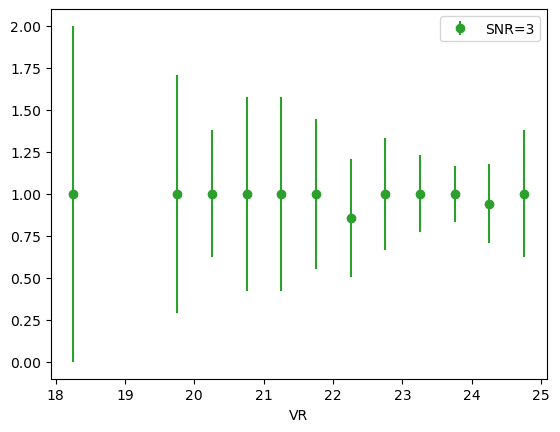

In [159]:
for c in pg_c.group_by("snr").groups:
    
    snr = c[0]['snr']
    cp = c['catalog_possible']
    sp = c['search_possible']
    t = c[cp & sp]
    print(t['found'].sum() / len(t))
    x, y, yerr = bin_detection(t, _x.min(), _x.max())
    plt.errorbar(x, y, yerr=yerr, fmt='o', label=f"SNR={snr}", color=f"C{-snr+5}")
    break

plt.legend()
plt.xlabel("VR")
plt.show()

In [213]:
def bin_function(c, k, dk, v, f, k_min=None, k_max=None):
    if k_min is None:
        k_min = c[k].min()
    if k_max is None:
        k_max = c[k].max()
    

    i = 0
    lower = k_min
    x = []
    y = []
    yerr = []
    cs = []
    while lower < k_max:    
        lower = k_min + i * dk
        upper = k_min + (i + 1) * dk
        a = c[(c[k] >= lower) & (c[k] < upper)]
        cs.append(a)
        if len(a) > 0:
            x.append((upper+lower)/2)
            y.append(f(a[v]))

        i += 1

    return np.array(x), np.array(y), cs
    


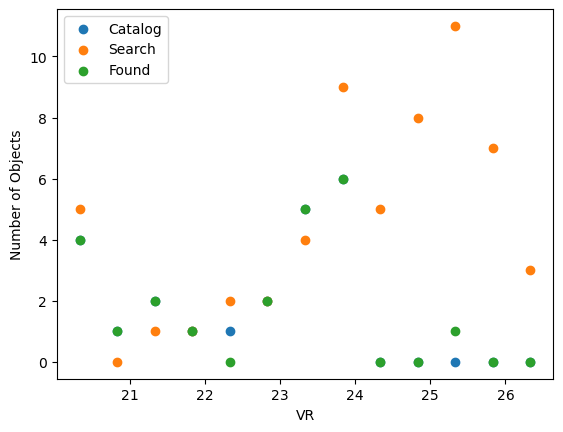

In [214]:
c = completeness("20190403/A0c", 5, detectors=[1, 3, 4, 5, 6, 7, 8, 9, 10])
x, y, _ = bin_function(c, "mag", 0.5, "catalog_possible", sum)
plt.scatter(x, y, label="Catalog")
x, y, _ = bin_function(c, "mag", 0.5, "search_possible", sum)
plt.scatter(x, y, label="Search")
x, y, _ = bin_function(c, "mag", 0.5, "found", sum)
plt.scatter(x, y, label="Found")

plt.legend()
plt.ylabel("Number of Objects")
plt.xlabel("VR")
plt.show()

Text(0, 0.5, 'N fakes')

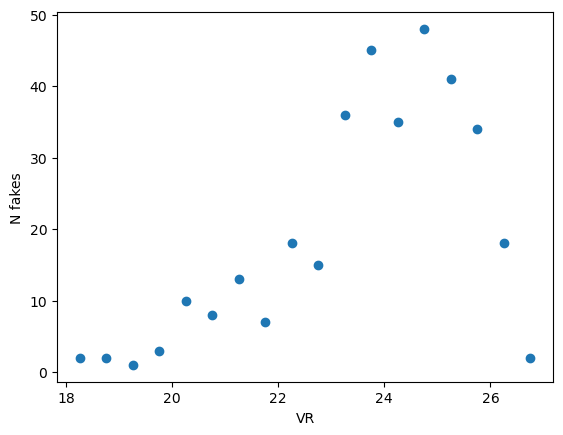

In [271]:
x, y, _ = bin_function(c, "mag", 0.5, "catalog_possible", len, k_min=k_min, k_max=k_max)
plt.scatter(x, y, label="Catalog")
plt.xlabel("VR")
plt.ylabel("N fakes")
# how to put errors into the completeness fits? shot noise is very high at the bright end

20190403/A0c 2 5 Ran out of input
20190403/A0c 21 5 Ran out of input
20190403/A0c 22 5 Ran out of input


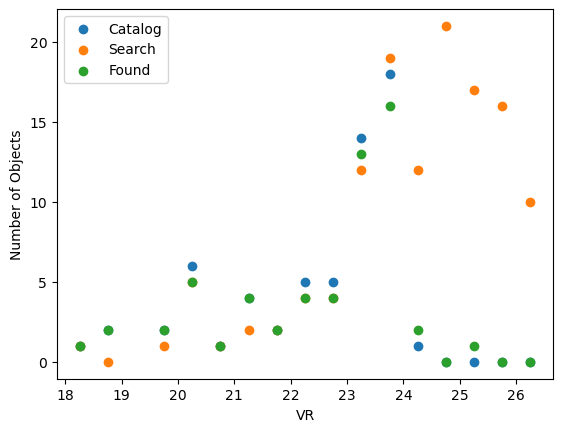

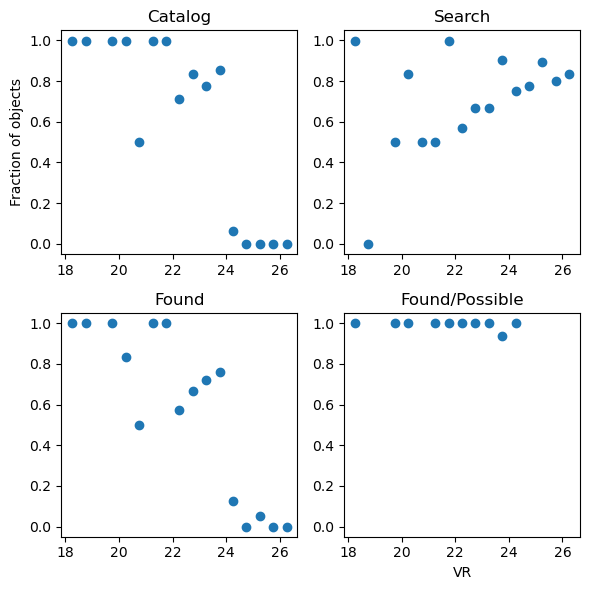

In [223]:
c = completeness(
    "20190403/A0c", 
    5, 
    detectors=list(range(1, 10)) + list(range(10, 20)) + list(range(20, 30))
)

k_min = c['mag'].min()
k_max = c['mag'].max()

x, y, _ = bin_function(c, "mag", 0.5, "catalog_possible", sum, k_min=k_min, k_max=k_max)
plt.scatter(x, y, label="Catalog")
x, y, _ = bin_function(c, "mag", 0.5, "search_possible", sum, k_min=k_min, k_max=k_max)
plt.scatter(x, y, label="Search")
x, y, _ = bin_function(c, "mag", 0.5, "found", sum, k_min=k_min, k_max=k_max)
plt.scatter(x, y, label="Found")

plt.legend()
plt.ylabel("Number of Objects")
plt.xlabel("VR")
plt.show()

fig = plt.figure(figsize=(6, 6))

x, y, _ = bin_function(c, "mag", 0.5, "catalog_possible", sum, k_min=k_min, k_max=k_max)
_, y_c, _ = bin_function(c, "mag", 0.5, "catalog_possible", len, k_min=k_min, k_max=k_max)
ax = fig.add_subplot(221)
plt.sca(ax)
plt.scatter(x, y/y_c, label="Catalog")
plt.ylabel("Fraction of objects")
plt.title("Catalog")

x, y, _ = bin_function(c, "mag", 0.5, "search_possible", sum, k_min=k_min, k_max=k_max)
_, y_c, _ = bin_function(c, "mag", 0.5, "search_possible", len, k_min=k_min, k_max=k_max)
ax = fig.add_subplot(222, sharex=ax, sharey=ax)
plt.sca(ax)
plt.scatter(x, y/y_c, label="Search")
plt.title("Search")

x, y, _ = bin_function(c, "mag", 0.5, "found", sum, k_min=k_min, k_max=k_max)
_, y_c, _ = bin_function(c, "mag", 0.5, "found", len, k_min=k_min, k_max=k_max)
ax = fig.add_subplot(223, sharex=ax, sharey=ax)
plt.sca(ax)
plt.scatter(x, y/y_c, label="Found")
plt.title("Found")


cp = c['catalog_possible']
sp = c['search_possible']
t = c[cp & sp]
x, y, _ = bin_function(t, "mag", 0.5, "found", sum, k_min=k_min, k_max=k_max)
_, y_c, _ = bin_function(t, "mag", 0.5, "found", len, k_min=k_min, k_max=k_max)
ax = fig.add_subplot(224, sharex=ax, sharey=ax)
plt.sca(ax)
plt.scatter(x, y/y_c, label="Found")
plt.title("Found/Possible")


# plt.legend()
# plt.ylabel("Number of Objects")
plt.xlabel("VR")
fig.tight_layout()
plt.show()

In [224]:
x, y, cs = bin_function(c, "mag", 0.5, "catalog_possible", sum, k_min=k_min, k_max=k_max)
_, y_c, _ = bin_function(c, "mag", 0.5, "catalog_possible", len, k_min=k_min, k_max=k_max)

In [225]:
x

array([18.25451487, 18.75451487, 19.75451487, 20.25451487, 20.75451487,
       21.25451487, 21.75451487, 22.25451487, 22.75451487, 23.25451487,
       23.75451487, 24.25451487, 24.75451487, 25.25451487, 25.75451487,
       26.25451487])

In [226]:
y/y_c

array([1.        , 1.        , 1.        , 1.        , 0.5       ,
       1.        , 1.        , 0.71428571, 0.83333333, 0.77777778,
       0.85714286, 0.0625    , 0.        , 0.        , 0.        ,
       0.        ])

In [230]:
c[(c['mag'] > 20.25451487) & (c['mag'] < 21.25451487)]

orbit,detector,mag,found,catalog_possible,search_possible
int64,int64,float64,bool,bool,bool
10464147,3,20.502337067556955,True,True,True
14699459,4,20.32811758025379,True,True,True
13711875,5,20.29613874022196,True,True,True
10464147,6,20.519058600413533,False,False,True
12371832,8,20.99915807732398,True,True,False
13182422,13,21.16394823184085,True,True,True
13700317,19,21.0471176365043,True,True,True
12959106,28,20.26003798802332,True,True,True


In [227]:
cs[5]

orbit,detector,mag,found,catalog_possible,search_possible
int64,int64,float64,bool,bool,bool
10464147,6,20.519058600413533,False,False,True
12371832,8,20.99915807732398,True,True,False


In [231]:
catalog, detector_fakes, recovery, catalog_findable, search_findable, clusters = load_recovery(
    "20190403/A0c", 6, 5
)

In [241]:
bin_function(detector_fakes, "MAG", 0.5, "ORBITID", lambda x : len(set(x)))

(array([20.7663964, 21.2663964, 24.2663964, 24.7663964, 25.2663964,
        25.7663964]),
 array([2, 1, 2, 3, 3, 2]),
 [<Table length=41>
           RA                 DEC         EXPNUM ...        MAG           type  
        float64             float64       int32  ...      float64         str8  
  ------------------- ------------------- ------ ... ------------------ --------
   -143.3112620164513 -11.155099825112329 845872 ... 20.519058600413533 asteroid
  -143.31155549005214 -11.154716608935933 845873 ... 20.518615890652992 asteroid
  -143.31186022138527 -11.154318741485524 845874 ...  20.51815727064107 asteroid
  -143.31215379390596 -11.153935487962158 845875 ... 20.517716478072238 asteroid
  -143.31244796502338 -11.153551494484656 845876 ... 20.517275804759887 asteroid
  -143.31274248780016 -11.153167081401996 845877 ...   20.5168356266754 asteroid
   -143.3130370610403  -11.15278263949656 845878 ...  20.51639639651782 asteroid
  -143.41160690187314 -11.167318644885073 845942 ...

In [198]:
c['detector'] == 22

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

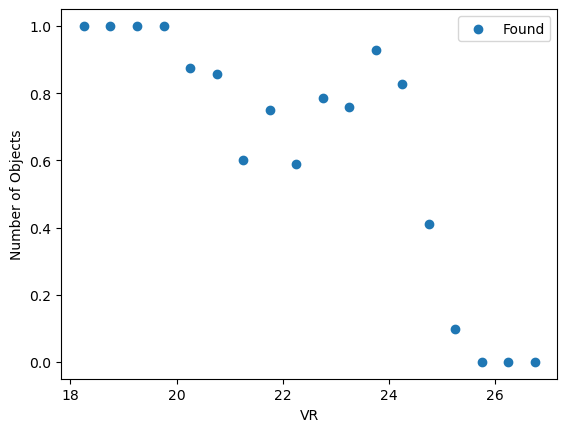

In [174]:
for c in pg_c.group_by("snr").groups:
    snr = c[0]['snr']
#     cp = c['catalog_possible']
#     sp = c['search_possible']
#     x, y = bin_function(c, "mag", 0.5, "catalog_possible", sum)
#     y_c = y
#     plt.scatter(x, y, label="Catalog")
#     x, y = bin_function(c, "mag", 0.5, "search_possible", sum)
#     plt.scatter(x, y, label="Search")
    x, y = bin_function(c, "mag", 0.5, "found", sum)
    _, y_c = bin_function(c, "mag", 0.5, "found", len)
    plt.scatter(x, y/y_c, label="Found")
    break

plt.legend()
plt.ylabel("Number of Objects")
plt.xlabel("VR")
plt.show()

In [148]:
for i in range(len(x) - 1):
    print(i)
    print(t[(t['mag'] < x[i + 1]) & (t['mag'] >= x[i])])

0
orbit detector mag found catalog_possible search_possible snr
----- -------- --- ----- ---------------- --------------- ---
1
 orbit   detector        mag         found catalog_possible search_possible snr
-------- -------- ------------------ ----- ---------------- --------------- ---
14929644       15 18.840810471979818  True             True           False   3
13314392       24  18.80501921829842  True             True           False   3
2
 orbit   detector        mag         found catalog_possible search_possible snr
-------- -------- ------------------ ----- ---------------- --------------- ---
12689843       28  19.74435244953803  True             True           False   3
14423962       42 19.455490083442236  True             True           False   3
3
 orbit   detector        mag         found catalog_possible search_possible snr
-------- -------- ------------------ ----- ---------------- --------------- ---
14969959        4  20.08346033742506  True             True         

In [145]:
t[(t['mag'] < x[2]) & (t['mag'] >= x[1])]

orbit,detector,mag,found,catalog_possible,search_possible,snr
int64,int64,float64,bool,bool,bool,int64
14929644,15,18.840810471979818,True,True,False,3
13314392,24,18.80501921829842,True,True,False,3


3
4
5


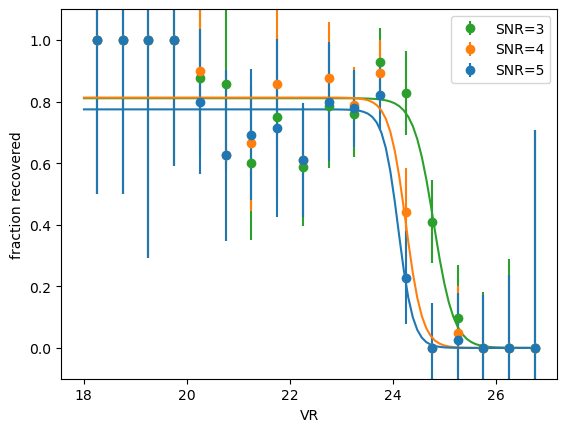

In [136]:
_x = np.linspace(pg_c['mag'].min(), pg_c['mag'].max(), 100)

for c in pg_c.group_by("snr").groups:
    snr = c[0]['snr']
    x, y, yerr = bin_detection(c, _x.min(), _x.max())
#     plt.scatter(c['mag'], c['found'], label=f"SNR={snr}")
    plt.errorbar(x, y, yerr=yerr, fmt='o', label=f"SNR={snr}", color=f"C{-snr+5}")
    
for fit in fits:
    snr = fit['snr']
    print(snr)
    plt.plot(_x, p(_x, fit['c'], fit['k'], fit['m_50']), color=f"C{-snr+5}")
    
plt.ylim(-0.1, 1.1)
plt.legend()
plt.xlabel("VR")
plt.ylabel("fraction recovered")
plt.show()

In [255]:
snrs

[3.5, 3.0, 5.0, 4.0, 4.5]

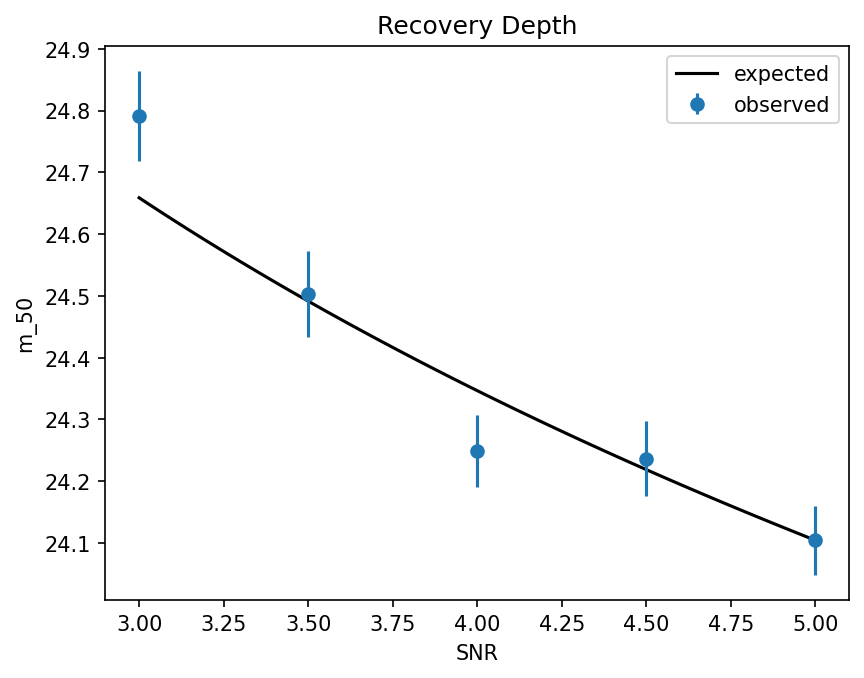

In [258]:
snrs = list(set(fits['snr']))
half_mag = [fits[fits['snr'] == snr]['m_50'][0] for snr in snrs]
half_mag_err = [fits[fits['snr'] == snr]['sigma_m_50'][0] for snr in snrs]
_snrs = np.linspace(min(snrs), max(snrs), 100)
expected = -5/2*np.log10(_snrs/max(snrs)) + half_mag[snrs.index(max(snrs))]

fig = plt.figure(dpi=150, facecolor="white")
plt.plot(_snrs, expected, label="expected", c='k')
plt.errorbar(snrs, half_mag, yerr=half_mag_err, fmt="o", label="observed")
plt.xlabel("SNR")
plt.ylabel("m_50")
plt.legend()
plt.title("Recovery Depth")
plt.show()

[Errno 2] No such file or directory: '../search/tmp/DEEP/20190403/A0c/detector_5/snr_3/recovery.pkl'
[Errno 2] No such file or directory: '../search/tmp/DEEP/20190403/A0c/detector_6/snr_3/recovery.pkl'
[Errno 2] No such file or directory: '../search/tmp/DEEP/20190403/A0c/detector_10/snr_3/recovery.pkl'


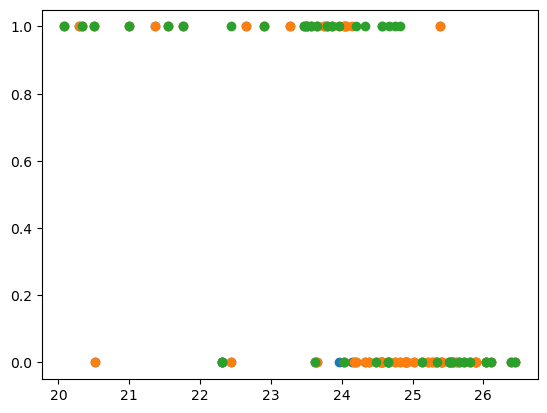

In [70]:
d = []

for snr in [5, 4, 3]:
    c = completeness("20190403/A0c", snr)
    c['snr'] = snr
    d.append(c)
    plt.scatter(c['mag'], c['found'])
    
plt.show()

In [46]:
search_findable[10041343]

{'vra': <Quantity -0.29713809 deg / d>,
 'vdec': <Quantity -0.09604964 deg / d>,
 'min_dv': <Quantity 0.10993634 deg / d>,
 'distance': <Quantity 0.01961038 deg>,
 'findable': False}

In [22]:
findable = {}
for orbit in set(detector_fakes['ORBITID']):
    findable[orbit] = (catalog_findable[orbit] > 25) & (search_findable[orbit]['findable'])
    
findable

{13039521: False,
 10564514: False,
 14621325: True,
 10053463: False,
 13776855: True,
 14813564: False,
 10041343: False}

In [27]:
catalog_findable

{13039521: 1,
 10564514: 0,
 14621325: 85,
 10053463: 3,
 13776855: 72,
 14813564: 64,
 10041343: 100}

In [30]:
recovery

{10041343: {145: 1, 201: 3, 204: 5, 233: 2, 386: 1, 442: 1, 517: 99},
 10053463: {},
 10564514: {},
 13039521: {},
 13776855: {58: 72},
 14621325: {42: 85},
 14813564: {91: 60, 159: 60}}

10041343 True 22.42943705005781
10053463 False 25.519660320084146
10564514 False 26.041395418882704
13039521 False 26.39768282519579
13776855 True 23.799304654954085
14621325 True 21.755897962503614
14813564 True 24.2012042804041


In [32]:
p = clusters.clusters[91]

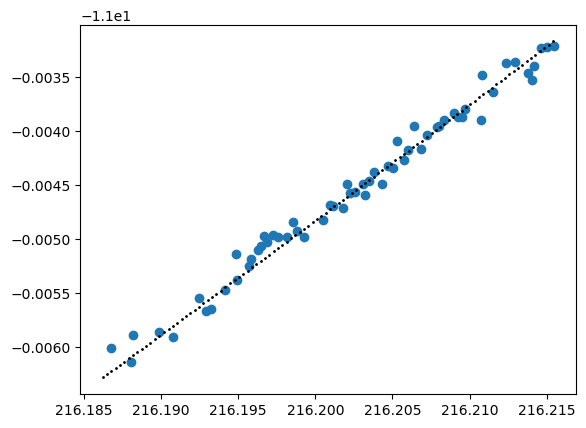

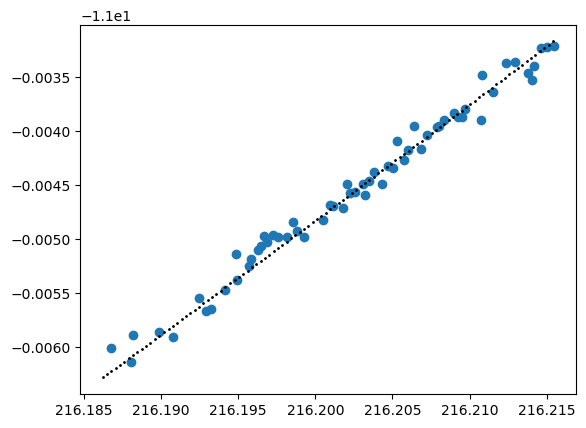

In [43]:
import matplotlib.pyplot as plt

plot_cluster(clusters.clusters[91])
plot_fake(14813564, detector_fakes, c='k', s=1)
# plt.title(detector_fakes[detector_fakes['ORBITID'] == 14813564][0]['MAG'])
plt.show()

plot_cluster(clusters.clusters[159])
plot_fake(14813564, detector_fakes, c='k', s=1)
plt.show()